# Quantum Double Slit Experiment

---

## Introduction and Learning Objectives

This notebook is a deeply documented, educational resource for simulating the double slit experiment using both classical and quantum computational methods. It is intended for learners, researchers, and practitioners interested in quantum algorithms, numerical physics, and scientific computing.

### What You Will Learn
- The physical and mathematical background of the double slit experiment.
- How to discretize and encode a wave equation on a 2D grid.
- How to implement boundary conditions and obstacles (slits) in both classical and quantum settings.
- The principles of Quantum Signal Processing (QSP) and Quantum Singular Value Transformation (QSVT) for quantum linear algebra.
- How to visualize complex-valued fields using color and animation.
- How to compare quantum and classical solutions quantitatively and visually.

### Structure of the Notebook
Each section is introduced with a markdown cell that explains the purpose, background, and expected outcomes. Code cells are extensively commented, and mathematical steps are explained in context. You are encouraged to read the markdown, run the code, and experiment with parameters.

### Key Concepts
- **Hamiltonian Construction:** The Hamiltonian encodes the physics of the double slit experiment, including the Laplacian, boundary conditions, and slit geometry.
- **Classical Solution:** Solving the linear system $H \psi = \text{source}$ gives the field distribution.
- **Quantum Solution:** The same problem is mapped to a quantum circuit, and QSP/QSVT is used to approximate the matrix inverse.
- **Visualization:** Both amplitude and phase are visualized using HSV color mapping, and quantum results are animated to show phase evolution.
- **Fidelity:** The overlap between quantum and classical solutions is computed to assess quantum algorithm accuracy.

### How to Use This Notebook
1. **Read the explanations** in each markdown cell.
2. **Run the code cells** in order, observing the outputs and visualizations.
3. **Modify parameters** (e.g., grid size, frequency, slit configuration) to explore different scenarios.
4. **Compare the results** and reflect on the similarities and differences between classical and quantum approaches.

---

Continue to the next sections for detailed, step-by-step implementation and analysis.

omega1 (normalized angular frequency): 1.1780972450961724
diag (Hamiltonian diagonal term): -2.612086881096809
encoding scale (Hamiltonian normalization): 11.836260643290428
Hamiltonian singular values: (np.float64(0.5507400024633752), np.float64(0.01184874011425535))


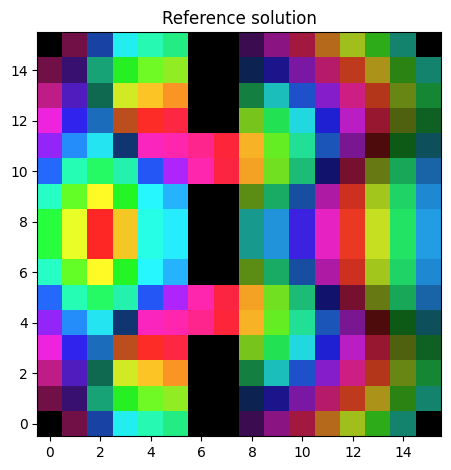

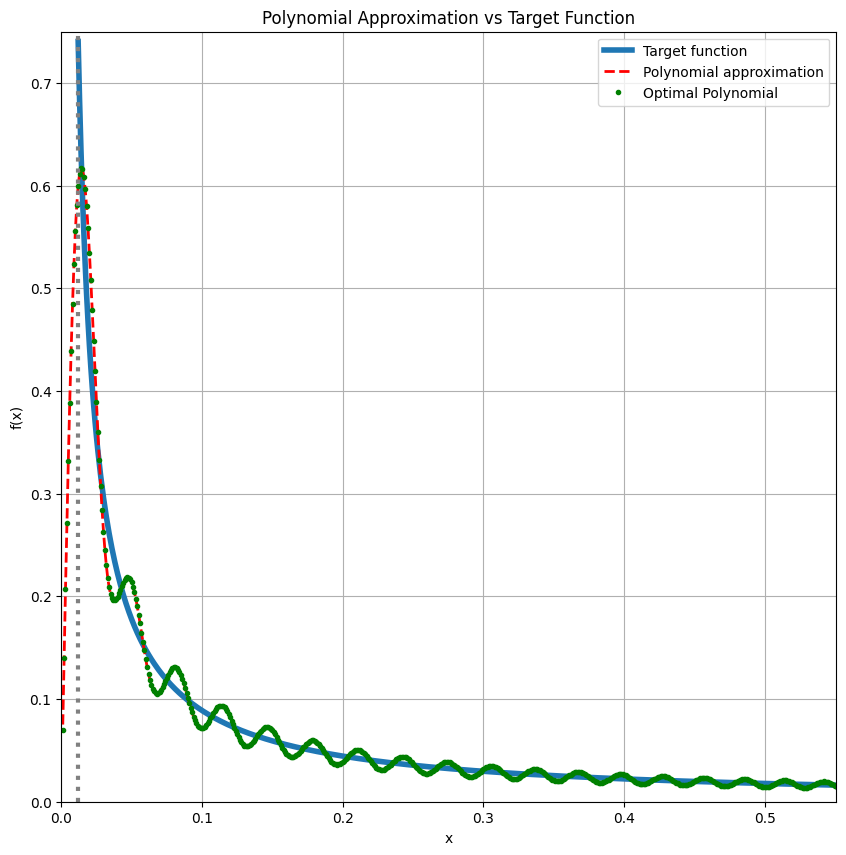

Expected fidelity: 0.9809080489008082
Starting model creation...
Model created successfully.
Starting synthesis...
Program synthesized successfully.
Program width: 18
Starting execution...
Execution completed successfully.
State vector probability: 0.04579582126260026
fidelity 0.9809080489008286


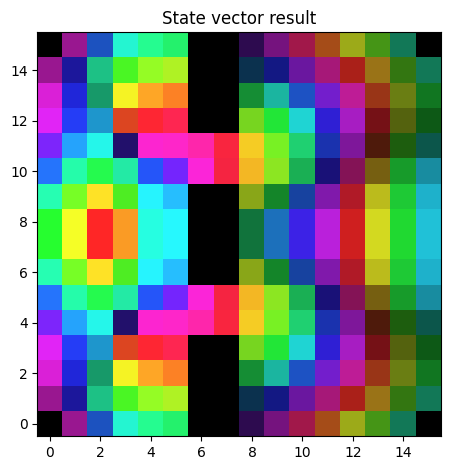

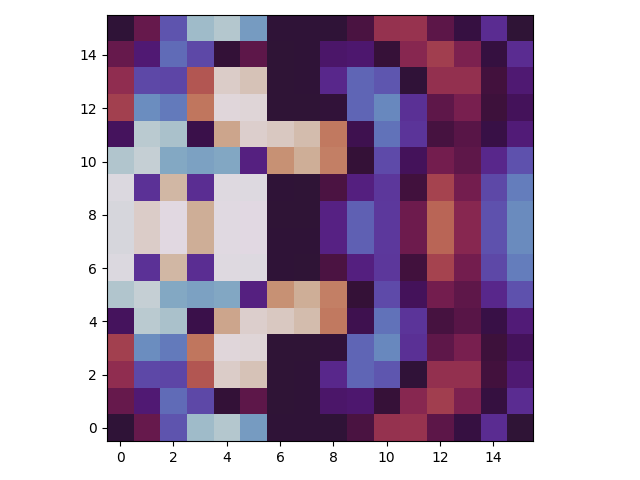

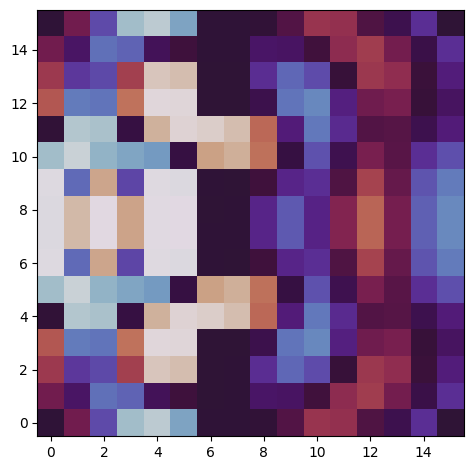

In [1]:
# ---
# SECTION 1: Import Libraries and Define Utilities
#
# This section imports all required libraries for numerical computation, visualization, and quantum simulation.
#
# - itertools: Efficient looping and combinatorics, used for grid and slit logic.
# - tempfile: Temporary file creation, used for saving and displaying GIF animations.
# - IPython.display.Image: Inline display of images and GIFs in Jupyter.
# - enum, typing: Type annotations and enumerations for code clarity and safety.
# - matplotlib, numpy, scipy: Core scientific Python stack for plotting, numerical arrays, and scientific computing.
# - classiq: Quantum circuit synthesis and simulation platform, used for quantum model construction and execution.
# - matplotlib.animation, matplotlib.colors: Advanced visualization and color mapping for field and phase plots.
#
# The following code also defines utility functions and constants used throughout the notebook, with detailed comments for each step.
#
!pip install -qq "classiq[qsp]"
import itertools  # For efficient looping and combinatorics, e.g., for slit removal
import tempfile  # For creating temporary files (used in GIF animation)
from enum import Enum  # For defining modes and configuration enums
from typing import Any, Iterable, List  # For type annotations

import matplotlib.pyplot as plt  # For plotting and visualization
import numpy as np  # For numerical arrays and linear algebra
import scipy  # For scientific computing (e.g., FFT, Chebyshev polynomials)
from IPython.display import Image  # For displaying GIFs inline in the notebook
from matplotlib.animation import FuncAnimation  # For creating animated GIFs
from matplotlib.colors import hsv_to_rgb  # For HSV color mapping

from classiq import *  # Classiq platform for quantum circuit synthesis and simulation
from classiq.applications.qsp import qsvt_phases
from classiq.qmod.symbolic import pi


# ---
# SECTION 2: Simulation Parameters and Physical Constants
#
# Here we define all the physical and simulation parameters for the double slit experiment.
#
# - n_x, n_y: Number of qubits (bits) in the x and y directions, determining the resolution of the simulation grid.
# - c, f0, omega0: Physical constants for the wave equation (speed of light, frequency, angular frequency).
# - sources_xy, sources_phase: Locations and phases of the sources that emit the wave.
# - Boundary and slit configuration: Determines where the slits (openings) and obstacles are placed in the grid.
#
# The code also includes utility functions for amplitude normalization and state preparation, with detailed explanations.
#
class Mode(str, Enum):
    DENSE = "DENSE"  # Dense mode for quantum circuit construction
    PRETTY = "PRETTY"  # Pretty mode (alternative, not used here)


MODE = Mode.DENSE  # Use dense mode for this notebook


def get_amplitudes(source: Iterable[float], target: Iterable[float]) -> List[float]:
    """
    Compute normalized amplitudes for quantum state preparation.
    Used to prepare the initial quantum state corresponding to the source vector.
    Args:
        source: Iterable of source amplitudes (reference values)
        target: Iterable of target amplitudes (desired values)
    Returns:
        List of normalized amplitudes for quantum state preparation.
    """
    source = np.array(source, dtype=float)
    target = np.array(target, dtype=float)
    res = np.sqrt(target / source)
    res = (res / np.linalg.norm(res)).tolist()
    return res


# ---
# Grid and Hamiltonian Parameters
#
n_x = 4  # Number of bits/qubits in x direction (controls grid resolution)
n_y = 4  # Number of bits/qubits in y direction
should_remove = (n_y >= 3) and (
    n_x >= 3
)  # Whether to include slit removal logic (for double slit)
L_x = 2**n_x  # Number of grid points in x (spatial resolution)
L_y = 2**n_y  # Number of grid points in y
dL = 1 / max(L_x, L_y)  # Grid spacing (normalized to 1)
LL = L_x * L_y  # Total number of grid points (system size)

# ---
# Physical Constants for the Wave Equation
#
c = 1  # Speed of light (arbitrary units)
f0 = 3  # Frequency of the source (arbitrary units)
j0 = 1  # Not used directly, but could represent current density
omega0 = 2 * np.pi * f0  # Angular frequency
omega1 = omega0 * dL / c  # Normalized angular frequency (for discretized grid)
diag = (
    omega1**2 - 4
)  # Diagonal term for the Hamiltonian (from discretized wave equation)
should_negate = diag < 0  # Whether to negate a term (for stability in quantum encoding)
diag_abs = np.abs(diag)  # Absolute value for amplitude encoding
abc_phase = np.angle(
    (1 + 0.5j * omega1) / (-1 + 0.5j * omega1) * (-1 if should_negate else 1)
)  # Phase for absorbing boundary condition
amplitudes1 = get_amplitudes(
    [1 / 4, 1 / 2, 1, 1], [1, diag_abs, diag_abs, 0]
)  # Amplitudes for block encoding
encoding_scale = (
    4 + 2 * diag_abs + diag_abs
)  # Normalization factor for Hamiltonian encoding

# Print key simulation parameters for reference
print("omega1 (normalized angular frequency):", omega1)
print("diag (Hamiltonian diagonal term):", diag)
print("encoding scale (Hamiltonian normalization):", encoding_scale)

# ---
# Identity and Zero Matrices for Grid Construction
#
id_L_x = np.eye(L_x, dtype=float)  # Identity matrix for x dimension
id_L_y = np.eye(L_y, dtype=float)  # Identity matrix for y dimension
zero_LL = np.zeros((LL, LL))  # Zero matrix for the full grid
id_LL = np.eye(LL, dtype=float)  # Identity matrix for the full grid

# ---
# Source Configuration: Two Sources Near the Bottom Center
#
num_sources = 2  # Number of sources (for double slit, typically 2)
sources_xy = [
    [L_x // 2, max(L_y // 8, 1)],
    [L_x // 2 - 1, max(L_y // 8, 1)],
]  # Source positions (x, y)
sources_phase = [1, 1]  # Source phases (can be complex for more general cases)

# Prepare the initial source vector (normalized)
source_vec = np.zeros(LL, dtype=complex)
for source in range(num_sources):
    _x, _y = sources_xy[source]
    _xy = _x * L_y + _y
    source_vec[_xy] = sources_phase[source]
source_vec = source_vec / np.linalg.norm(source_vec)

# Indices for permutation logic (used in quantum state preparation)
source_ij = [0] * num_sources
for source in range(num_sources):
    _x, _y = sources_xy[source]
    _xy = _x * L_y + _y
    source_ij[source] = _xy

# Single-qubit source amplitudes (for quantum state preparation)
source_single_qubit = np.array(sources_phase)
source_single_qubit = source_single_qubit / np.linalg.norm(source_single_qubit)

# Initial state as a list (used for both classical and quantum initialization)
init = source_vec.tolist()


# ---
# SECTION 3: Classical Hamiltonian Construction and Solution
#
# This section constructs the discretized Hamiltonian matrix for the 2D grid, including boundary conditions and slit removal logic.
# The matrix is then solved classically to obtain the reference solution for the field distribution.
#
# - Laplacian and boundary terms are constructed using numpy operations.
# - Slit removal is implemented by zeroing out matrix rows/columns corresponding to obstacles.
# - The classical solution is obtained by direct matrix inversion.
#
_semi_lap_x = np.roll(id_L_x, 1, 0) + np.roll(id_L_x, -1, 0)
_semi_lap_y = np.roll(id_L_y, 1, 0) + np.roll(id_L_y, -1, 0)

grad_amp = diag * (1 + 0.5j * omega1) / (-1 + 0.5j * omega1)

_grad_f_x = np.zeros((1, L_x), dtype=complex)
_grad_f_x[0, :2] = np.array([0, grad_amp])
_grad_f_y = np.zeros((1, L_y), dtype=complex)
_grad_f_y[0, :2] = np.array([0, grad_amp])
_grad_b_x = np.zeros((1, L_x), dtype=complex)
_grad_b_x[0, -2:] = np.array([grad_amp, 0])
_grad_b_y = np.zeros((1, L_y), dtype=complex)
_grad_b_y[0, -2:] = np.array([grad_amp, 0])

grad_f_x = (
    np.tensordot(_grad_f_x, id_L_y, axes=0).transpose(0, 2, 1, 3).reshape(L_y, LL)
)
grad_f_y = (
    np.tensordot(id_L_x, _grad_f_y, axes=0).transpose(0, 2, 1, 3).reshape(L_x, LL)
)
grad_b_x = (
    np.tensordot(_grad_b_x, id_L_y, axes=0).transpose(0, 2, 1, 3).reshape(L_y, LL)
)
grad_b_y = (
    np.tensordot(id_L_x, _grad_b_y, axes=0).transpose(0, 2, 1, 3).reshape(L_x, LL)
)

semi_lap_x = (
    np.tensordot(_semi_lap_x, id_L_y, axes=0).transpose(0, 2, 1, 3).reshape(LL, LL)
)
semi_lap_y = (
    np.tensordot(id_L_x, _semi_lap_y, axes=0).transpose(0, 2, 1, 3).reshape(LL, LL)
)

mat_em = np.array(semi_lap_x + semi_lap_y, dtype=complex)

mat_em[:L_y] = 0
mat_em[::L_y] = 0
mat_em[-L_y:] = 0
mat_em[L_y - 1 :: L_y] = 0
mat_em[:L_y] += grad_f_x
mat_em[-L_y:] += grad_b_x
mat_em[::L_y] += grad_f_y
mat_em[L_y - 1 :: L_y] += grad_b_y
mat_em[0] = 0
mat_em[L_y - 1] = 0
mat_em[-L_y] = 0
mat_em[-1] = 0


if should_remove:
    start_idx_x_0 = 0
    end_idx_x_0 = 2 * 2 ** (n_x - 3)
    start_idx_x_1 = 3 * 2 ** (n_x - 3)
    end_idx_x_1 = 5 * 2 ** (n_x - 3)
    start_idx_x_2 = 6 * 2 ** (n_x - 3)
    end_idx_x_2 = L_x
    start_idx_y = 3 * 2 ** (n_y - 3)
    end_idx_y = 4 * 2 ** (n_y - 3)

    for _x in itertools.chain(
        range(start_idx_x_0, end_idx_x_0),
        range(start_idx_x_1, end_idx_x_1),
        range(start_idx_x_2, end_idx_x_2),
    ):
        for _y in range(start_idx_y, end_idx_y):
            idx = _x * L_y + _y
            mat_em[idx, :] = 0
            mat_em[:, idx] = 0

mat_em = mat_em + diag * id_LL

svd = np.linalg.svd(mat_em / encoding_scale, compute_uv=True)
print("Hamiltonian singular values:", (svd[1][0], svd[1][-1]))

ref = np.linalg.solve(mat_em, init)


def normalize_phase(data: np.ndarray) -> np.ndarray:
    """
    Normalize the phase of a complex vector so that the maximum amplitude is real and positive.
    This is useful for comparing quantum and classical solutions up to a global phase.
    Args:
        data: Complex numpy array (state vector)
    Returns:
        Phase-normalized numpy array
    """
    _max = max(data, key=np.abs)
    return data * (np.abs(_max) / _max)


ref = normalize_phase(ref)


# ---
# SECTION 4: Visualization Utilities
#
# This section provides functions for visualizing complex-valued fields using HSV color mapping and for plotting results.
#
def complex2HSV(z: np.ndarray, percentile: float = 50, hue_start: float = 0):
    """
    Convert a complex-valued array to an HSV color image for visualization.
    Amplitude is mapped to brightness, phase to hue.
    Args:
        z: Complex numpy array
        percentile: Percentile for amplitude scaling (for contrast)
        hue_start: Phase offset for hue mapping
    Returns:
        RGB image as numpy array
    """
    amp = np.abs(z)
    scale = 1 / np.percentile(amp, percentile)
    f = lambda var: np.tanh(scale * var)
    amp = f(amp)
    ph = np.angle(z, deg=1) + hue_start
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = amp / np.max(amp)
    return hsv_to_rgb(np.dstack((h, s, v)))


def hsv_plot(data: np.ndarray, title: str = ""):
    """
    Plot a complex-valued 2D array using HSV color mapping.
    Args:
        data: 2D complex numpy array
        title: Plot title
    """
    _data = data / np.linalg.norm(data, ord="fro")
    __data = complex2HSV(_data)
    plt.imshow(
        __data,
        origin="lower",
        aspect="equal",
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


hsv_plot(ref.reshape((L_x, L_y)), "Reference solution")


# ---
# SECTION 5: Polynomial Approximation for Quantum Signal Processing (QSP)
#
# This section defines helper functions for constructing the optimal polynomial approximation required for QSP/QSVT-based matrix inversion.
# Chebyshev polynomials and DCT are used to generate the coefficients.
#
def y_from_x(x, a):
    """
    Helper function for Chebyshev polynomial evaluation in QSP.
    Maps x to y according to the transformation in the QSP literature.
    Args:
        x: Input value(s)
        a: Parameter for mapping
    Returns:
        Transformed value(s)
    """
    return (2.0 * x**2 - (1.0 + a**2)) / (1.0 - a**2)


def P_eval(x, d, a):
    """
    Evaluate the optimal odd polynomial P_{2n-1}(x; a) for QSP/QSVT.
    Uses Chebyshev polynomials and the mapping from QSP theory.
    Args:
        x: Input value(s)
        d: Degree (must be odd)
        a: Parameter for mapping
    Returns:
        Evaluated polynomial values
    """
    if d % 2 == 0:
        raise ValueError("d must be odd")
    n = (d + 1) // 2
    x = np.asarray(x, dtype=float)

    # main branch
    y = y_from_x(x, a)
    Ln = scipy.special.eval_chebyt(n, y)
    L0 = scipy.special.eval_chebyt(n, y_from_x(0.0, a))
    out = (1.0 - (Ln / L0)) / x

    return out


def P_chebyshev(d: int, a: float):
    """
    Compute Chebyshev-T coefficients of the optimal polynomial for QSP/QSVT.
    Uses DCT-II on Chebyshev–Gauss nodes.
    Args:
        d: Degree (must be odd)
        a: Parameter for mapping
    Returns:
        Chebyshev coefficients as numpy array
    """
    if d % 2 == 0:
        raise ValueError("d must be odd (degree = d = 2n-1).")

    N = d + 1
    xk = np.cos(np.pi * (np.arange(N) + 0.5) / N)  # Chebyshev–Gauss nodes

    yk = P_eval(xk, d, a)  # sample your polynomial
    c = 2 * scipy.fft.dct(yk, type=2, norm="forward")
    # (Optional) enforce odd parity numerically if desired:
    c[0::2] = 0.0

    return c


def chebT_coeffs_fm(
    m: int,
    w_min: float,
    w_max: float = 1.0,
    scale: float = 0.5,
    plot: bool = True,
):
    """
    Compute and (optionally) plot Chebyshev coefficients for QSP polynomial approximation.
    Args:
        m: Degree of polynomial
        w_min: Minimum singular value (domain start)
        w_max: Maximum singular value (domain end)
        scale: Scaling factor for the polynomial
        plot: Whether to plot the approximation
    Returns:
        Chebyshev coefficients as numpy array
    """
    if m % 2 == 0:
        m = m - 1

    c = (scale * w_min) * P_chebyshev(m, w_min)

    xj = 1 - np.linspace(0, 1, 1000, endpoint=False)
    xj_target = xj[(xj >= w_min)]

    if plot:
        y_target = (scale * w_min) / xj_target
        y_approx = np.polynomial.Chebyshev(c)(xj)
        y_P = P_eval(xj, m, w_min) * (scale * w_min)

        # Plot
        plt.figure(figsize=(10, 10))
        plt.plot(xj_target, y_target, label="Target function", linewidth=4)
        plt.plot(
            xj,
            y_approx,
            "--",
            label="Polynomial approximation",
            linewidth=2,
            c="r",
        )
        plt.plot(
            xj,
            y_P,
            ".",
            label="Optimal Polynomial",
            linewidth=1,
            c="g",
        )
        plt.title("Polynomial Approximation vs Target Function")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        # Draw vertical lines
        plt.axvline(w_min, color="gray", linestyle=":", linewidth=3)
        plt.xlim(0, w_max)
        plt.ylim(0, scale)
        plt.legend()
        plt.grid(True)
        plt.show()

    return c.astype(float)


pcoefs = chebT_coeffs_fm(
    np.round(0.75 * max(L_x, L_y) ** 2), svd[1][-1], svd[1][0], scale=0.75, plot=True
)


# ---
# SECTION 6: Quantum Signal Processing (QSP) Phase Sequence Preparation
#
# This section prepares the phase sequence for QSP/QSVT, converting it to the convention required by the quantum circuit implementation.
# The phase sequence is used for quantum matrix inversion in the quantum algorithm.
#
inv_svd = np.polynomial.Chebyshev(pcoefs)(svd[1])
best = (svd[2].conjugate().T * inv_svd) @ (svd[0].conjugate().T @ init)

expected_fidelity = (
    np.abs(best.conjugate().T @ ref) / np.linalg.norm(best) / np.linalg.norm(ref)
) ** 2

print("Expected fidelity:", expected_fidelity)
assert expected_fidelity >= 0.95, "Expected fidelity is too low"


ang_seq = qsvt_phases(pcoefs)


BLOCK_SIZE = 6


# ---
# SECTION 7: Quantum Model Construction and Execution
#
# This section defines the quantum data structures, quantum functions, and the main quantum model for the double slit experiment.
# It includes the logic for encoding the Hamiltonian, boundary conditions, and slit removal in the quantum circuit.
# The quantum circuit is synthesized and executed using the Classiq platform, and the resulting state vector is extracted for analysis.
#
class E_Field(QStruct):
    y: QArray[n_y]
    x: QArray[n_x]


class BlockEncodedState(QStruct):
    block: QNum[BLOCK_SIZE]
    data: E_Field


@qperm
def equals(val: int, qvar1: Const[QNum], target: QBit) -> None:
    target ^= qvar1 == val


@qfunc
def demi_semi_laplacian(
    r: QNum,
    block: QBit,
) -> None:
    within_apply(
        lambda: H(block),
        lambda: (
            control(block == 1, lambda: inplace_add(-1, r)),
            control(block == 0, lambda: inplace_add(1, r)),
        ),
    )


@qperm
def remove_scatterer_statement(x: Const[QNum], y: Const[QNum], block: QBit) -> None:
    block ^= (~((x == 2) ^ (x == 5))) & (y == 3)


@qperm
def remove_scatterer(
    e_field: E_Field,
    block: QBit,
) -> None:
    if MODE == Mode.DENSE:
        temp_x = QBit()
        within_apply(
            lambda: (
                allocate(temp_x),
                X(temp_x),
                equals(2, e_field.x[n_x - 3 : n_x], temp_x),
                equals(5, e_field.x[n_x - 3 : n_x], temp_x),
            ),
            lambda: (equals(1 + 2 * 3, [temp_x, e_field.y[n_y - 3 : n_y]], block),),
        )
    elif MODE == Mode.PRETTY:
        remove_scatterer_statement(
            e_field.x[n_x - 3 : n_x], e_field.y[n_y - 3 : n_y], block
        )


@qfunc
def semi_laplacian(
    e_field: E_Field,
    block: QArray[2],
) -> None:
    within_apply(
        lambda: H(block[1]),
        lambda: (
            control(block[1] == 0, lambda: demi_semi_laplacian(e_field.x, block[0])),
            control(block[1] == 1, lambda: demi_semi_laplacian(e_field.y, block[0])),
        ),
    )


@qperm
def boundary_flag(r: Const[QArray], flag: QBit) -> None:
    equals(0, r, flag)
    equals((1 << r.len) - 1, r, flag)


def boundary_condition(r: Any) -> Any:
    return (r == 0) ^ (r == (1 << r.size) - 1)


@qperm
def semi_laplacian_removed_statement(
    flag_scatterer: Const[QBit], x: Const[QNum], y: Const[QNum], block: QBit
) -> None:
    block ^= flag_scatterer | boundary_condition(x) | boundary_condition(y)


@qfunc
def semi_laplacian_removed(
    e_field: E_Field,
    block: QArray[4],
) -> None:
    if MODE == Mode.DENSE:
        remove_scatterer(e_field, block[2]) if should_remove else None
        semi_laplacian(e_field, block[0:2])
        flag_scatterer = QBit()
        flag_x = QBit()
        flag_y = QBit()
        within_apply(
            lambda: (
                allocate(flag_scatterer),
                remove_scatterer(e_field, flag_scatterer) if should_remove else None,
                allocate(flag_x),
                boundary_flag(e_field.x, flag_x),
                allocate(flag_y),
                boundary_flag(e_field.y, flag_y),
            ),
            lambda: (
                equals(0, [flag_scatterer, flag_x, flag_y], block[3]),
                X(block[3]),
            ),
        )
    elif MODE == Mode.PRETTY:
        remove_scatterer(e_field, block[2]) if should_remove else None
        semi_laplacian(e_field, block[0:2])
        flag_scatterer = QBit()
        within_apply(
            lambda: (
                allocate(flag_scatterer),
                remove_scatterer(e_field, flag_scatterer) if should_remove else None,
            ),
            lambda: semi_laplacian_removed_statement(
                flag_scatterer,
                e_field.x,
                e_field.y,
                block[3],
            ),
        )


@qperm
def demi_semi_abc_statement(
    r: Const[QNum],
    block: QBit,
) -> None:
    block ^= ~boundary_condition(r)


@qperm
def demi_semi_abc(
    r: QArray,
    block: QBit,
) -> None:
    if MODE == Mode.DENSE:
        X(r[0])
        boundary_flag(r, block)
        X(block)
    elif MODE == Mode.PRETTY:
        X(r[0])
        demi_semi_abc_statement(r, block)


@qperm
def semi_abc_statement(
    x: Const[QNum],
    y: Const[QNum],
    block: QBit,
) -> None:
    block ^= ~(boundary_condition(x) ^ boundary_condition(y))


@qfunc
def semi_abc(
    e_field: E_Field,
    block: QArray[3],
) -> None:
    if MODE == Mode.DENSE:
        within_apply(
            lambda: H(block[1]),
            lambda: (
                control(block[1] == 0, lambda: demi_semi_abc(e_field.x, block[0])),
                control(block[1] == 1, lambda: demi_semi_abc(e_field.y, block[0])),
            ),
        )
        boundary_flag(e_field.x, block[2])
        boundary_flag(e_field.y, block[2])
        X(block[2])
    elif MODE == Mode.PRETTY:
        within_apply(
            lambda: H(block[1]),
            lambda: (
                control(block[1] == 0, lambda: demi_semi_abc(e_field.x, block[0])),
                control(block[1] == 1, lambda: demi_semi_abc(e_field.y, block[0])),
            ),
        )
        semi_abc_statement(e_field.x, e_field.y, block[2])


@qfunc
def hamiltonian(
    e_field: E_Field,
    block: QArray[BLOCK_SIZE],
) -> None:
    block1 = QArray(None, QBit, 4)
    block2 = QNum()
    within_apply(
        lambda: (
            bind(block, [block1, block2]),
            inplace_prepare_amplitudes(amplitudes1, 0.0, block2),
        ),
        lambda: (
            control(
                block2 == 0,
                lambda: semi_laplacian_removed(e_field, block1),
            ),
            control(
                block2 == 1,
                lambda: (
                    semi_abc(e_field, block1[0:3]),
                    U(0, 0, 0, abc_phase, block1[0]),
                ),
            ),
            (
                control(block2 == 2, lambda: U(0, 0, 0, pi, block1[0]))
                if should_negate
                else None
            ),
        ),
    )


@qperm
def _inplace_xor(i: int, target: QNum) -> None:
    inplace_xor(i, target)


@qperm
def permute_block(i: int, j: int, data: QArray):
    """
    Returns the permutation operation of i->0 and j->1 in the qubit register data.
    """
    assert i != j

    # move the i state to the 0 state

    ### Why cant I use inplace_xor??? This used to work!!!
    _inplace_xor(i, data)

    # update j
    j = j ^ i
    if j == 1:
        return
    # get the last index for which j is not 0
    pivot = j.bit_length() - 1
    # remove pivot from j
    j = j % (1 << pivot)

    # move the j state to the 0 state
    control(data[pivot], lambda: _inplace_xor(j, data[0:pivot]))
    SWAP(data[0], data[pivot])


@qfunc
def inplace_prepare_init(data: QArray):
    inplace_prepare_amplitudes(source_single_qubit, 0.0, data[0])
    invert(lambda: permute_block(*source_ij, data))


@qfunc
def main(res: Output[QNum[n_x + n_y]], block: Output[QNum[BLOCK_SIZE + 1]]) -> None:
    state = BlockEncodedState()
    allocate(state)
    inplace_prepare_init(state.data)
    aux = QBit()
    allocate(aux)
    qsvt_inversion(
        ang_seq,
        lambda _aux: equals(0, state.block, _aux),
        lambda: hamiltonian(state.data, state.block),
        aux,
    )
    bind([aux, state], [block, res])


print("Starting model creation...")
qmod = create_model(
    main,
    constraints=Constraints(max_width=1000),
    preferences=Preferences(
        debug_mode=False,
        transpilation_option="none",
        optimization_level=0,
        timeout_seconds=1200,
    ),
)
print("Model created successfully.")
print("Starting synthesis...")
qprog = synthesize(qmod, auto_show=False)
print("Program synthesized successfully.")
print("Program width:", qprog.data.width)

Execution_Prefs = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)

print("Starting execution...")
with ExecutionSession(qprog, execution_preferences=Execution_Prefs) as es:
    es.set_measured_state_filter("block", lambda state: state == 0)
    res_1 = es.sample()
print("Execution completed successfully.")

df = res_1.dataframe.sort_values("res")
state_result_1 = df[(df.block == 0)].amplitude.values
state_result_1 = normalize_phase(state_result_1)

state_result_prob = sum(np.abs(state_result_1) ** 2)
print("State vector probability:", state_result_prob)

print(
    "fidelity",
    (
        np.abs(ref.conjugate() @ state_result_1)
        / np.linalg.norm(state_result_1)
        / np.linalg.norm(ref)
    )
    ** 2,
)

hsv_plot(state_result_1.reshape((L_x, L_y)), "State vector result")


# ---
# SECTION 8: Visualization of Quantum Results and Animation
#
# This section provides a function to animate the quantum field result as a GIF, showing phase evolution over time.
# The GIF is saved and displayed inline in the notebook.
#
def show_gif(
    data: np.ndarray,
    fps: int = 30,
    duration: float = 2,
    percentile: float = 70,
    title: str = "",
    output_file: str = None,
):
    """
    Save a GIF from the given data to a file and display it inline in the notebook.
    Args:
        data (np.ndarray): The input data array (typically a 2D field).
        fps (int): Frames per second for the GIF.
        duration (float): Duration of the GIF in seconds.
        percentile (float): Percentile for scaling the data (for contrast).
        title (str): Title for the frames.
        output_file (str): Optional file path to save the GIF.
    """
    frames = int(fps * duration)
    scale = 1 / np.percentile(np.abs(data), percentile)
    f = lambda var: np.tanh(scale * var)

    fig, ax = plt.subplots()
    im = ax.imshow(
        f(data.real),
        origin="lower",
        aspect="equal",
        cmap="twilight",
        vmin=-1,
        vmax=1,
    )
    ax.set_title(title)

    def update(frame):
        _data = f((np.exp(-1j * 2 * np.pi * frame / frames) * data).real)
        im.set_array(_data)
        return [im]

    plt.tight_layout()

    anim = FuncAnimation(
        fig, update, frames=range(frames), interval=duration * 1000 / frames, blit=True
    )

    # Use a temporary file if no output_file is provided
    if output_file is None:
        temp_file = tempfile.NamedTemporaryFile(suffix=".gif", delete=False)
        output_file = temp_file.name
        temp_file.close()

    anim.save(output_file, writer="pillow", fps=fps)

    # Display the saved GIF
    display(Image(filename=output_file))


show_gif(state_result_1.reshape((L_x, L_y)))